# Set-Up

In [ ]:
!pip install textstat
!pip install pyspellchecker
!pip install textblob
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import re

import nltk
from nltk import pos_tag, word_tokenize

from matplotlib import pyplot as plt
import seaborn as sns

from textstat import flesch_reading_ease, gunning_fog
from spellchecker import SpellChecker
from textblob import TextBlob
from collections import Counter

from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('universal_tagset')

In [ ]:
FILE_PATH = "/content/drive/MyDrive/BT4012 Group 16!!/" # change the file path accordingly

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(f"{FILE_PATH}fake_job_postings.csv", keep_default_na=True) # automatically treat certain null values as "NaN"
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col) # strips leading & trailing spaces in text fields
df = df.replace(r'^\s*$', np.nan, regex=True) # replace any cell that's entirely empty after stripping leading & trailing spaces with NaN

print("Dataset Size:")
print(df.shape)

df.head(5)

# Train-Test Split

In [ ]:
train_df = pd.read_csv(f"{FILE_PATH}train_df.csv", keep_default_na=True) # automatically treat certain null values as "NaN"
train_df = train_df.apply(lambda col: col.str.strip() if col.dtype == "object" else col) # strips leading & trailing spaces in text fields
train_df = train_df.replace(r'^\s*$', np.nan, regex=True) # replace any cell that's entirely empty after stripping leading & trailing spaces with NaN

In [ ]:
# For generating of dataset for clustering in later sections
train_df_raw_clustering = train_df.copy()
test_df_raw_clustering = test_df.copy()

# For usage in main feature engineering function
train_df_copy = train_df.copy()

In [ ]:
test_df = pd.read_csv(f"{FILE_PATH}test_df.csv", keep_default_na=True) # automatically treat certain null values as "NaN"
test_df = test_df.apply(lambda col: col.str.strip() if col.dtype == "object" else col) # strips leading & trailing spaces in text fields
test_df = test_df.replace(r'^\s*$', np.nan, regex=True) # replace any cell that's entirely empty after stripping leading & trailing spaces with NaN

In [ ]:
# target column
y = df["fraudulent"]
X = df.drop(columns=["fraudulent"])

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Combine X and y back into full train/test DataFrames
train_df = X_train.copy()
train_df["fraudulent"] = y_train

test_df = X_test.copy()
test_df["fraudulent"] = y_test

# Display sizes
print("Dataset Size:", df.shape[0], "rows")
print("Train Size  :", train_df.shape[0], "rows")
print("Test Size   :", test_df.shape[0], "rows")

# Display class proportions
print("\nClass Proportions:")
print("Original:\n", y.value_counts(normalize=True))
print("Train:\n", y_train.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))

# Output train & test datasets
train_df.to_csv(f"{FILE_PATH}train_df.csv", index=False)
test_df.to_csv(f"{FILE_PATH}test_df.csv", index=False)

# Generic Checks

In [ ]:
# Check data type
train_df.dtypes

,0
job_id,int64
title,object
location,object
department,object
salary_range,object
company_profile,object
description,object
requirements,object
benefits,object
telecommuting,int64


In [ ]:
# Check for any duplicate
duplicates = train_df.duplicated()
num_duplicates = duplicates.sum()
print(f"No. of duplicate rows: {num_duplicates}")

No. of duplicate rows: 0


In [ ]:
#-- Check for unique categories in each col

# Basic cleaning of train_df and stored in train_df_clean to obtain count of unique values in each col
train_df_clean = train_df.copy()

for col in train_df_clean.columns:
    if train_df_clean[col].dtype == "object":   # Only clean string columns
        # Convert to string (preserve NaN), strip spaces, lowercase
        train_df_clean[col] = (
            train_df_clean[col]
            .astype(str)
            .str.strip()
            .str.lower()
            .replace({"": None, "nan": None})  # Normalise empties
        )

unique_counts_cleaned = train_df_clean.nunique(dropna=True)
print(unique_counts_cleaned)

job_id                 14304
title                   8865
location                2508
department              1070
salary_range             771
company_profile         1596
description            11916
requirements            9708
benefits                5018
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 129
function                  37
fraudulent                 2
dtype: int64


In [ ]:
# Checking null values in each col
null_counts_cleaned = train_df_clean.isna().sum()
print(null_counts_cleaned)

job_id                     0
title                      0
location                 280
department              9280
salary_range           12021
company_profile         2672
description                2
requirements            2134
benefits                5810
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         2757
required_experience     5675
required_education      6499
industry                3926
function                5169
fraudulent                 0
dtype: int64


# Helper Functions for EDA

In [ ]:
# Plots the top K most frequent categories
# Print stats about:
  # a. Coverage of the top K categories
  # b. Statistics of the subset selected (e.g. composition of fraudulent postings)

# Note: If NaN exists in the top K categories, we still plot it in the graph.
# However, we would include another category into the top K categories.
# For the printing of the stats, don't include the stats for NaN, since we want to know how much % those valid categories print.

def plot_top_k_distribution(df, column, top_k=None, hue='fraudulent'):
    if column not in df.columns:
        print(f"Column '{column}' not found in DataFrame.")
        return

    # Copy df
    df = df.copy()

    # Normalise text but preserve NaN
    df[column] = (
        df[column]
        .astype(str)
        .str.strip()
        .str.lower()
    )

    # Separate NaN values first
    is_nan_mask = df[column].isna()

    # Unique non-NaN categories
    non_nan_values = df.loc[~is_nan_mask, column]

    n_unique_non_nan = non_nan_values.nunique()
    if top_k is None or top_k > n_unique_non_nan:
        top_k = n_unique_non_nan

    # Compute top-k among *non-NaN*
    top_k_values = non_nan_values.value_counts().head(top_k).index.tolist()

    # Include NaN as a "pseudo category" for plotting only
    if len(df[df[column] == np.nan] > 0):
      plot_categories = top_k_values + [np.nan]
    else:
      plot_categories = top_k_values

    # Filter df for plotting
    df_plot = df[df[column].isin(plot_categories)]

    plt.figure(figsize=(12, 6))
    ax = sns.countplot(
        data=df_plot,
        x=column,
        hue=hue,
        order=plot_categories
    )

    plt.title(f"Distribution of `{hue}` by Top {top_k} {column.capitalize()} (NaN included)")
    plt.xlabel(column.capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)

    plt.show()

    # Print stats (excluding NaN)
    total_rows = len(df)
    total_fake = df[df[hue] == 1].shape[0]
    total_real = df[df[hue] == 0].shape[0]

    top_k_values = [x for x in top_k_values if x != "nan"]
    df_top = df[df[column].isin(top_k_values)]  # Exclude NaN

    top_rows = len(df_top)
    top_fake = df_top[df_top[hue] == 1].shape[0]
    top_real = df_top[df_top[hue] == 0].shape[0]

    pct_total_rows = top_rows / total_rows * 100
    pct_total_fake = top_fake / total_fake * 100 if total_fake else 0
    pct_total_real = top_real / total_real * 100 if total_real else 0
    pct_fake_subset = top_fake / top_rows * 100 if top_rows else 0
    pct_real_subset = top_real / top_rows * 100 if top_rows else 0

    print(f"Top {top_k} '{column}' categories cover {pct_total_rows:.2f}% of ALL rows (NaN excluded).")
    print(f"They cover {pct_total_fake:.2f}% of ALL fraudulent postings.")
    print(f"They cover {pct_total_real:.2f}% of ALL real postings.")
    print(f"Within this subset: {pct_fake_subset:.2f}% are fraudulent.")
    print(f"Within this subset: {pct_real_subset:.2f}% are real.")

In [ ]:
# Analyses missing categories to see whether there are entire categories that have missing values in the selected_col
# Helps determines if there are any patterns to the missing values in the columns
def analyse_fully_missing_categories(df, selected_col, target_col='fraudulent'):

    if selected_col not in df.columns:
        print(f"Column '{selected_col}' not found.")
        return

    df_check = df.copy()
    df_check[f"has_{selected_col}"] = df_check[selected_col].notnull().astype(int)

    # Columns to exclude (too large or irrelevant for the prints)
    excluded_cols = [
        selected_col,
        'job_id', 'title', 'department', 'company_profile',
        'description', 'requirements', 'benefits', 'salary_range'
    ]
    compare_cols = [c for c in df_check.columns if c not in excluded_cols]

    # Ensure fraudulent appears first
    if target_col in compare_cols:
        compare_cols.remove(target_col)
        compare_cols = [target_col] + compare_cols

    has_0 = df_check[df_check[f"has_{selected_col}"] == 0]

    print(f"\n--- FULL Missingness Associations for `{selected_col}` ---")

    found_any_column = False  # Track if any column has results

    for col in compare_cols:

        unique_values = has_0[col].unique()
        fully_missing_values = []  # store categories under this column

        for val in unique_values:
            # Identify rows with the same category
            if pd.isna(val):
                rows_same_category = df_check[df_check[col].isna()]
            else:
                rows_same_category = df_check[df_check[col] == val]

            has_0_count = (rows_same_category[f"has_{selected_col}"] == 0).sum()
            has_1_count = (rows_same_category[f"has_{selected_col}"] == 1).sum()

            # If this category ONLY appears when selected_col is missing
            if has_1_count == 0 and has_0_count > 0:
                fully_missing_values.append((val, has_0_count))

       # Print detailed categories (only those with count > 1)
        values_gt1 = [(val, c) for val, c in fully_missing_values if c > 1]

        if values_gt1 and col != f"has_{col}":
            found_any_column = True
            print(f"\n>>> Column: `{col}`")

            for val, count in values_gt1:
                print(f"    • Category `{val}` → ONLY appears when `{selected_col}` is missing (rows: {count})")

            # NEW: print the total sum for this column
            total_gt1 = sum(c for _, c in values_gt1)
            print(f"    >> Total rows for categories with count > 1: {total_gt1}")

    if not found_any_column:
        print("No categories fully associated with missingness.")

In [ ]:
train_df_compare = train_df.copy() # for usage in missingness analysis

In [ ]:
# Summarises missingness for each column in `columns`.

# For each column, computes:
#     - missing_count
#     - missing_pct
#     - missing_and_fraud_count
#     - missing_and_fraud_pct_of_fraud


def print_missing_summary(df, columns, target_col="fraudulent"):
    summary = {}
    n = len(df)

    total_fraud = (df[target_col] == 1).sum()

    for col in columns:
        if col not in df.columns:
            print(f"Column '{col}' not found, skipping.")
            continue

        s = df[col]
        is_missing = s.isna()

        missing_count = is_missing.sum()
        missing_and_fraud = ((is_missing) & (df[target_col] == 1)).sum()

        summary[col] = {
            "missing_count": missing_count,
            "missing_pct": round((missing_count / n) * 100, 4),
            "missing_and_fraud_count": missing_and_fraud,
            "missing_and_fraud_pct_of_fraud": round(
                (missing_and_fraud / total_fraud * 100), 4
            ) if total_fraud > 0 else 0
        }

    summary_df = pd.DataFrame(summary).T
    return summary_df

# 1. Text Columns


1. title   
2. department
3. company_profile
4. description
5. requirements
6. benefits



In [ ]:
TEXT_COLS = ["title", "department", "company_profile", "description", "requirements", "benefits"]

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, "department")


--- FULL Missingness Associations for `department` ---

>>> Column: `location`
    • Category `GB, RIC, Twickenham` → ONLY appears when `department` is missing (rows: 15)
    • Category `US, CO, Denver (metro)` → ONLY appears when `department` is missing (rows: 6)
    • Category `US, TX, Round Rock` → ONLY appears when `department` is missing (rows: 6)
    • Category `US, AZ, Tucson` → ONLY appears when `department` is missing (rows: 3)
    • Category `GB, , Twickenham` → ONLY appears when `department` is missing (rows: 4)
    • Category `US, WI, Stevens Point` → ONLY appears when `department` is missing (rows: 2)
    • Category `US, VA, Chesapeake` → ONLY appears when `department` is missing (rows: 11)
    • Category `US, NY, New  York` → ONLY appears when `department` is missing (rows: 2)
    • Category `US, WV, Fairmont` → ONLY appears when `department` is missing (rows: 2)
    • Category `BE, , Brussels` → ONLY appears when `department` is missing (rows: 34)
    • Category `US, CA

In [ ]:
analyse_fully_missing_categories(train_df_compare, "company_profile")


--- FULL Missingness Associations for `company_profile` ---

>>> Column: `location`
    • Category `PH, , Quezon City` → ONLY appears when `company_profile` is missing (rows: 16)
    • Category `LT, ,` → ONLY appears when `company_profile` is missing (rows: 6)
    • Category `US, CO, Louisville` → ONLY appears when `company_profile` is missing (rows: 2)
    • Category `GR, I, Vrilissia, Athens` → ONLY appears when `company_profile` is missing (rows: 2)
    • Category `US, NY, Port Chester` → ONLY appears when `company_profile` is missing (rows: 3)
    • Category `BY, HM, Minsk` → ONLY appears when `company_profile` is missing (rows: 2)
    • Category `GB, ABD,` → ONLY appears when `company_profile` is missing (rows: 2)
    • Category `GB, CHW, Chester/North Wales` → ONLY appears when `company_profile` is missing (rows: 2)
    • Category `US, NY, Uniondale` → ONLY appears when `company_profile` is missing (rows: 3)
    • Category `PL, MA, Kraków` → ONLY appears when `company_profile` i

In [ ]:
analyse_fully_missing_categories(train_df_compare, "description")


--- FULL Missingness Associations for `description` ---

>>> Column: `has_description`
    • Category `0` → ONLY appears when `description` is missing (rows: 2)
    >> Total rows for categories with count > 1: 2


In [ ]:
analyse_fully_missing_categories(train_df_compare, "requirements")


--- FULL Missingness Associations for `requirements` ---

>>> Column: `location`
    • Category `NL, NH, Hilversum` → ONLY appears when `requirements` is missing (rows: 16)
    • Category `US, CA, Los Angeles County` → ONLY appears when `requirements` is missing (rows: 2)
    • Category `NZ, N, Alk` → ONLY appears when `requirements` is missing (rows: 2)
    • Category `US, NJ, Secaucus` → ONLY appears when `requirements` is missing (rows: 8)
    • Category `GB, , Milton Keynes` → ONLY appears when `requirements` is missing (rows: 4)
    • Category `US, NY, Uniondale` → ONLY appears when `requirements` is missing (rows: 3)
    • Category `US, NC, Mooresville` → ONLY appears when `requirements` is missing (rows: 3)
    • Category `AT, 5, Salzburg` → ONLY appears when `requirements` is missing (rows: 3)
    • Category `US, NY, Niagara Falls` → ONLY appears when `requirements` is missing (rows: 14)
    • Category `US, WY, Cheyenne` → ONLY appears when `requirements` is missing (rows: 3)


In [ ]:
analyse_fully_missing_categories(train_df, "benefits")


--- FULL Missingness Associations for `benefits` ---

>>> Column: `location`
    • Category `GB, RIC, Twickenham` → ONLY appears when `benefits` is missing (rows: 15)
    • Category `IN, WB, Kolkata` → ONLY appears when `benefits` is missing (rows: 6)
    • Category `IL, , Tel Aviv` → ONLY appears when `benefits` is missing (rows: 11)
    • Category `GB, , Twickenham` → ONLY appears when `benefits` is missing (rows: 4)
    • Category `US, CO, Louisville` → ONLY appears when `benefits` is missing (rows: 2)
    • Category `NL, NH, Hilversum` → ONLY appears when `benefits` is missing (rows: 16)
    • Category `US, CA, Los Angeles County` → ONLY appears when `benefits` is missing (rows: 2)
    • Category `US, IA, Wever` → ONLY appears when `benefits` is missing (rows: 2)
    • Category `US, CA, North Hollywood` → ONLY appears when `benefits` is missing (rows: 5)
    • Category `US, CA, Newark` → ONLY appears when `benefits` is missing (rows: 5)
    • Category `CA, ON, Cambridge` → ONLY ap

In [ ]:
print_missing_summary(train_df, TEXT_COLS)

# `department`: Missing department is very common in general and very common among fraud postings. tied to a few industries e.g. Photography --> But very small proportion out of the entire dataset.
# `description`: Small percentage of missing value in `description`
# `company_profile`: Highest missing rate among the 4 text columns
# `benefits`: Suggests that certain industries have completely missing values e.g.  Machinery, Government Relations, Animation
# All `company_profile`, `requirements`, `benefits` have missing values associated with certain locations. --> But very small proportion out of the entire dataset.

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
title,0.0,0.0000,0.0,0.0000
department,9280.0,64.8770,434.0,62.6263
company_profile,2672.0,18.6801,484.0,69.8413
description,2.0,0.0140,2.0,0.2886
requirements,2134.0,14.9189,121.0,17.4603
benefits,5810.0,40.6180,298.0,43.0014


## b. Pre-Processing for Feature Engineering

In [ ]:
#-- Creates 3 derived columns from `column`, for different feature engineering purposes
# f"{column}_noencoded": original casing, URLs/placeholders removed
  # Kept non-letters for feature engineering purposes
# f"{column}_clean_has_punctuation": lowercase, URLs/placeholders removed, non-english chars stripped
# f"{column}_clean_no_punctuation": no punctuation at all

def preprocess_text_columns(df, columns):
  df = df.copy()

  # Compile regexes once
  placeholder_re = re.compile(r'#(?:URL|EMAIL|PHONE)_[A-Za-z0-9_]+#') # Detects encoded placeholders (URL, Email, Phone)
  direct_re = re.compile(r'http\S+|www\S+|@\S+') # Direct URL / email patterns
  punctuation_re = re.compile(r'[^\w\s]') # punctuations
  nonalpha_re = re.compile(r'[^A-Za-z0-9\s\.,!?;:\-\(\)\'\"]') # Non-alphabet / punc / digit characters
  ws_re = re.compile(r'\s+') # Whitespace normalisation

  def remove_encoded_placeholders(text: str) -> str:
      # Remove encoded placeholders and direct URLs/emails/handles, keep casing
      text = placeholder_re.sub(' ', text)
      text = direct_re.sub(' ', text)
      return text

  def clean_keep_punct(text: str) -> str:
        text = text.lower()
        text = placeholder_re.sub(' ', text)
        text = direct_re.sub(' ', text)
        # keep punctuation
        text = ws_re.sub(' ', text).strip()
        return text

  def clean_remove_punct(text: str) -> str:
      text = text.lower()
      text = placeholder_re.sub(' ', text)
      text = direct_re.sub(' ', text)
      text = punctuation_re.sub(' ', text)  # remove punctuation
      text = ws_re.sub(' ', text).strip()
      return text

  for col in columns:
    base = df[col].fillna('').astype(str)

    # 1. Stylised text (punctuation, digits, uppercase retained)
    df[f'{col}_noencoded'] = base.apply(remove_encoded_placeholders)

    # 2. Clean — keep punctuation (for readability, grammar, sentiment)
    df[f'{col}_clean_has_punctuation'] = base.apply(clean_keep_punct)

    # 3. Clean — remove punctuation (for POS tagging)
    df[f'{col}_clean_no_punctuation'] = base.apply(clean_remove_punct)

  return df

In [ ]:
train_df = preprocess_text_columns(train_df, TEXT_COLS)

# # Check
# train_df.head(5)

## c. Basic Text Statistics

In [ ]:
# Adds text-structure statistics for each column in `columns`.
# Uses the `<col>_noencoded` version of the text.

# Creates for each column:
#     - <col>_char_count
#     - <col>_word_count
#     - <col>_sentence_count
#     - <col>_avg_word_length
#     - <col>_avg_sentence_length
#     - <col>_unique_word_normalised
#     - <col>_unique_char_normalised
#     - <col>_digit_ratio
#     - <col>_special_char_ratio
#     - <col>_longest_repeated_chars_length

def add_text_statistics(df, columns):
    df = df.copy()

    for column in columns:

        # --- Validate dependency: must have _noencoded column ---
        if f"{column}_noencoded" not in df.columns:
            raise ValueError(
                f"Column '{column}_noencoded' not found. "
                f"Run preprocess_text() first for column '{column}'."
            )

        noencoded_col = df[f"{column}_noencoded"]

        # Precompute splits
        words_list = noencoded_col.apply(lambda x: x.split())
        word_counts = words_list.apply(len)
        char_counts = noencoded_col.apply(len)

        df[f"{column}_char_count"] = char_counts
        df[f"{column}_word_count"] = word_counts
        df[f"{column}_sentence_count"] = noencoded_col.apply(lambda x: len(re.findall(r'[.!?]+', x)))

        # Average word length
        df[f"{column}_avg_word_length"] = words_list.apply(
            lambda ws: float(np.mean([len(w) for w in ws])) if ws else 0.0
        )

        # Words per sentence (avoid /0)
        df[f"{column}_avg_sentence_length"] = df.apply(
            lambda row: row[f"{column}_word_count"] / (row[f"{column}_sentence_count"] + 1),
            axis=1
        )

        # Unique word ratio
        df[f"{column}_unique_word_normalised"] = words_list.apply(
            lambda ws: len(set(ws)) / (len(ws) + 1)
        )

        # Unique char ratio
        df[f"{column}_unique_char_normalised"] = noencoded_col.apply(
            lambda x: len(set(x)) / (len(x) + 1)
        )

        # Digit ratio
        df[f"{column}_digit_ratio"] = noencoded_col.apply(
            lambda x: sum(c.isdigit() for c in x) / (len(x) + 1)
        )

        # Special character ratio (non alphanumeric + non-space)
        df[f"{column}_special_char_ratio"] = noencoded_col.apply(
            lambda x: sum(not c.isalnum() and not c.isspace() for c in x) / (len(x) + 1)
        )

        # Longest repeated character sequence
        def longest_run(text):
            if not text:
                return 0
            longest = 1
            current = 1
            for i in range(1, len(text)):
                if text[i] == text[i-1]:
                    current += 1
                    longest = max(longest, current)
                else:
                    current = 1
            return longest

        df[f"{column}_longest_repeated_chars_length"] = noencoded_col.apply(longest_run)


    return df

In [ ]:
train_df = add_text_statistics(train_df, TEXT_COLS)

In [ ]:
def preprocess_and_add_domain_features(df, text_cols, money_exclude=["department"], money_pattern=None):
    """
    ADD-ON FUNCTION that:
        ✔ Uses already-created clean text columns from preprocess_text_columns()
        ✔ Adds domain-specific fraud indicators:
            - <col>_contains_remote_keywords
            - <col>_contains_money_terms  (except excluded columns)

    Does NOT overwrite any text cleaning columns.
    """

    df = df.copy()

    # Remote keywords
    remote_keywords = [
        "remote", "work from home", "telecommute", "telecommuting",
        "home-based", "work-from-home", "virtual position", "online job"
    ]
    remote_keywords = [kw.lower() for kw in remote_keywords]

    # If no money_pattern passed, skip it
    use_money = money_pattern is not None

    for col in text_cols:

        # Use the cleaned no-punctuation version created earlier
        clean_series = df[f"{col}_clean_no_punctuation"].fillna("")

        # 1. Remote keyword detection
        df[f"{col}_contains_remote_keywords"] = clean_series.apply(
            lambda x: int(any(kw in x for kw in remote_keywords))
        )

        # 2. Money-term detection (skip excluded)
        if use_money and col not in money_exclude:
            df[f"{col}_contains_money_terms"] = clean_series.apply(
                lambda x: int(bool(money_pattern.search(x)))
            )

    return df

In [ ]:
train_df = preprocess_and_add_domain_features(train_df, TEXT_COLS)

# 2. Long-Text Columns

1. company_profile  
2. description
3. requirements
4. benefits

In [ ]:
LONG_TEXT_COLS = ["company_profile", "description", "requirements", "benefits"]

## a. Basic features

In [ ]:
def add_contact_info_and_dup_indicator_to_text_cols(df, text_columns):
    df = df.copy()

    #-- 1. For each column in `columns`, detect URLs, emails and phone numbers, then add boolean flags:
      # {col}_has_url
      # {col}_has_email
      # {col}_has_phone
    # Note that these URL/email/phone in the dataset can contain formats
    # e.g. #URL_51d5a513a1c02d186ae6ab34dce2b8e4d4a88f6a2947c09722848f32d449feaa#
    # e.g. #EMAIL_c9b5d8a60f3d80be13dd02ffe5d212c047b92ba679c296dfae7c102952fbb534#
    # e.g. #PHONE_8f86665c8a76d925f761287bb38d6bb5f440845f2a5fa712361f255943a8b21b#
    url_re = re.compile(
        r'(?:https?://\S+|www\.\S+)|(?:#URL_[0-9a-fA-F]{64}#)'
    )
    email_re = re.compile(
        r'(?:\b[\w\.-]+@[\w\.-]+\.\w+\b)|(?:#EMAIL_[0-9a-fA-F]{64}#)'
    )
    phone_re = re.compile(
        r'(?:\+?\d[\d\- ]{7,}\d)|(?:#PHONE_[0-9a-fA-F]{64}#)'
    )

    def check_patterns(df, column):
        return pd.DataFrame({
            'has_url': df[column].str.contains(url_re, na=False),
            'has_email': df[column].str.contains(email_re, na=False),
            'has_phone': df[column].str.contains(phone_re, na=False),
        })

    for col in text_columns:
        # Contact-info flags
        temp = check_patterns(df, col)
        df[f"{col}_has_url"] = temp["has_url"].astype(int)
        df[f"{col}_has_email"] = temp["has_email"].astype(int)
        df[f"{col}_has_phone"] = temp["has_phone"].astype(int)

        #-- 2. Duplicate flags (BOOLEAN, not binary)
        s = df[col]
        mask_non_null = s.notna()
        dup_mask = s[mask_non_null].duplicated(keep=False)  # boolean mask

        # Initialize as Fals
        df[f"{col}_duplicated"] = False

        # Only update non-null rows
        df.loc[mask_non_null, f"{col}_duplicated"] = dup_mask

        df[f"{col}_duplicated"] = df[f"{col}_duplicated"].astype(int)

    return df

In [ ]:
train_df = add_contact_info_and_dup_indicator_to_text_cols(train_df, LONG_TEXT_COLS)

## b. Sentiment Analysis

In [ ]:
# Adds sentiment + emphasis features for each column in `columns`.
#   - {col}_sentiment_pos / neg / compound
#   - {col}_uppercase_ratio
#   - {col}_exclamation_count + normalised
#   - {col}_question_count + normalised
#   - {col}_all_caps_words + normalised
#   - {col}_digit_ratio

def add_sentiment_features(df, columns, sia=None):

    df = df.copy()

    # --- Prepare single VADER instance (efficient) ---
    if sia is None:
        try:
            from nltk.sentiment import SentimentIntensityAnalyzer
            sia = SentimentIntensityAnalyzer()
        except Exception as e:
            raise RuntimeError(
                "NLTK VADER not available. Install nltk and download 'vader_lexicon'."
            ) from e

    for col in columns:

        clean_col = df[f"{col}_clean_has_punctuation"]
        noencoded_col = df[f"{col}_noencoded"]

        #  1. Sentiment (VADER)
        scores = clean_col.apply(sia.polarity_scores)
        df[f"{col}_sentiment_pos"] = scores.apply(lambda d: d["pos"])
        df[f"{col}_sentiment_neg"] = scores.apply(lambda d: d["neg"])
        df[f"{col}_sentiment_compound"] = scores.apply(lambda d: d["compound"]) # overall sentiment polaritry of the description, normalised btwn -1 (most neg) and +1 (most pos), combining positive, negative and neutral tones into a single summary score.

        # 2. Emphasis / stylistic features

        # Uppercase ratio
        df[f"{col}_uppercase_ratio"] = (
            noencoded_col.apply(lambda x: sum(1 for c in x if c.isupper()))
            / (df[f"{col}_char_count"] + 1)
        )

        # Exclamation marks
        df[f"{col}_exclamation_count"] = noencoded_col.apply(
            lambda x: len(re.findall(r'\b\w+\s*\!+', x))
        )
        df[f"{col}_exclamation_normalised"] = (
            df[f"{col}_exclamation_count"] / (df[f"{col}_char_count"] + 1)
        )

        # Question marks
        df[f"{col}_question_count"] = noencoded_col.apply(
            lambda x: len(re.findall(r'\b\w+\s*\?+', x))
        )
        df[f"{col}_question_normalised"] = (
            df[f"{col}_question_count"] / (df[f"{col}_char_count"] + 1)
        )

        # ALL-CAPS words (words of 2+ uppercase letters)
        df[f"{col}_all_caps_words"] = noencoded_col.apply(
            lambda x: len(re.findall(r"\b[A-Z]{2,}\b", x))
        )
        df[f"{col}_all_caps_words_normalised"] = (
            df[f"{col}_all_caps_words"] / (df[f"{col}_word_count"] + 1)
        )

    return df

In [ ]:
train_df = add_sentiment_features(train_df, LONG_TEXT_COLS)

## c. Readability

In [ ]:
# Adds readability + linguistic quality features for each text column in `columns`.
# Operates on <col>_noencoded for each selected column.
# Creates per column:
#     - <col>_flesch_score
#     - <col>_gunning_fog
#     - <col>_spelling_error_rate
#     - <col>_objective_score
#     - <col>_punctuation_diversity

def add_readability_and_quality_features(df, columns):
    df = df.copy()

    spell = SpellChecker()

    def spelling_error_rate(text):
        words = re.findall(r"[A-Za-z']+", text.lower())
        if not words:
            return 0
        misspelled = spell.unknown(words)
        return len(misspelled) / len(words)

    def objective_score(text):
        if not text.strip():
            return 0
        # 1 - subjectivity => higher = more objective (corporate tone)
        return 1 - TextBlob(text).sentiment.subjectivity

    for col in columns:

        noencoded_name = f"{col}_noencoded"
        if noencoded_name not in df.columns:
            raise ValueError(
                f"Missing '{noencoded_name}'. Run preprocess_text(df, '{col}') first."
            )

        series = df[noencoded_name]

        # Readability (skip short texts)
        df[f"{col}_flesch_score"] = series.apply(
            lambda x: flesch_reading_ease(x) if len(x) > 50 else 0
        )
        df[f"{col}_gunning_fog"] = series.apply(
            lambda x: gunning_fog(x) if len(x) > 50 else 0
        )

        # Spelling quality
        df[f"{col}_spelling_error_rate"] = series.apply(spelling_error_rate)

        # Objective_Score
        df[f"{col}_objective_score"] = series.apply(objective_score)

    return df

In [ ]:
train_df = add_readability_and_quality_features(train_df, LONG_TEXT_COLS)

## d. POS tagging

In [ ]:
def add_pos_tagging(df: pd.DataFrame, columns: list, tagset: str = "universal"):

    df = df.copy()

    def pos_counts(text):
        text = str(text) if text is not None else ""
        tokens = word_tokenize(text)
        if not tokens:
            return Counter(TOTAL_TOKENS=0)
        tags = pos_tag(tokens, tagset=tagset)
        counts = Counter(tag for _, tag in tags)
        counts["TOTAL_TOKENS"] = len(tokens)
        return counts

    for column in columns:

        clean_col = f"{column}_clean_no_punctuation"
        if clean_col not in df.columns:
            raise ValueError(
                f"Missing '{clean_col}'. Run preprocess_text(df, '{column}') first."
            )

        # Apply POS counting
        pos_features = df[clean_col].fillna("").apply(pos_counts)
        pos_df = pd.DataFrame(list(pos_features)).fillna(0)

        # Prefix POS columns to avoid naming collisions
        prefix = f"{column}_POS_"
        pos_df = pos_df.add_prefix(prefix)

        # Concatenate
        pos_df = pos_df.reset_index(drop=True)
        df = df.reset_index(drop=True)
        df = pd.concat([df, pos_df], axis=1)

        # Normalisation
        total_col = f"{prefix}TOTAL_TOKENS"
        total_tokens = df[total_col].replace(0, 1)

        for col in pos_df.columns:
            if col == total_col:
                continue
            df[f"{col}_normalised"] = df[col] / total_tokens

    return df

In [ ]:
train_df = add_pos_tagging(train_df, LONG_TEXT_COLS)

# `location` Column

In [ ]:
# Examine unique values in location column
train_df['location'].value_counts().head(10)

,count
location,
"GB, LND, London",591
"US, NY, New York",538
"US, CA, San Francisco",373
"GR, I, Athens",372
"US, ,",276
"US, TX, Houston",225
"US, IL, Chicago",196
"US, DC, Washington",192
"NZ, N, Auckland",185


## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'location')


--- FULL Missingness Associations for `location` ---

>>> Column: `has_location`
    • Category `0` → ONLY appears when `location` is missing (rows: 280)
    >> Total rows for categories with count > 1: 280


In [ ]:
print_missing_summary(train_df, ['location'])

# Small pptn of missing and fraud in location col

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
location,280.0,1.9575,16.0,2.3088


## b. Split into country, state, city

From inspection of the values in the `location` column, it appears that for the value in each position of the text separated by commas:
1. First position: Country code
2. Second position: State / Province / Region
3. City

Note that:
*   There can be entries e.g. "NZ, , Auckland", "SG, , " since some countries do not use state / city.
*   Or simply, "US, , " if the job listing does not provide full information





In [ ]:
# Split into 3 parts (country, state, city)
def split_location_columns(df, location_col="location"):

    df = df.copy()

    # Ensure column exists
    if location_col not in df.columns:
        raise ValueError(f"Column '{location_col}' not found in dataframe.")

    # Split into up to 3 parts
    split_cols = df[location_col].fillna("").astype(str).str.split(",", n=2, expand=True)

    # Assign names
    df[["country", "state", "city"]] = split_cols

    # Strip whitespace
    df["country"] = df["country"].str.strip()
    df["state"] = df["state"].str.strip()
    df["city"] = df["city"].str.strip()

    # Convert "" → NaN
    df[["country", "state", "city"]] = df[["country", "state", "city"]].replace("", np.nan)

    return df

In [ ]:
train_df = split_location_columns(train_df)

In [ ]:
# Check `country` col
print("--> Boolean to indicate if all null `country` rows also have null `location`")
print(f"{(train_df['country'].isna() == train_df['location'].isna()).all()}\n")

print("--> Examine unique values in `country` col to check if they are all correct")
print(train_df['country'].unique())
# After examining the values, we confirmed that they are all true `country` abbreviations.

--> Boolean to indicate if all null `country` rows also have null `location`
True

--> Examine unique values in `country` col to check if they are all correct
['US' 'NZ' 'HK' 'AM' 'GR' 'GB' 'IN' 'DE' 'IL' 'FI' 'SG' 'BE' 'CA' 'AU' nan
 'PH' 'LT' 'NL' 'PL' 'EG' 'EE' 'MY' 'RO' 'AR' 'KR' 'DK' 'BY' 'IE' 'IT'
 'SE' 'MX' 'BG' 'CN' 'BR' 'RU' 'FR' 'UA' 'ZA' 'AE' 'LU' 'CH' 'AT' 'TR'
 'MT' 'VN' 'SA' 'LV' 'ES' 'KE' 'IQ' 'BH' 'NG' 'MU' 'QA' 'PK' 'RS' 'TH'
 'SK' 'CL' 'ID' 'PA' 'JP' 'PT' 'CY' 'ZM' 'NO' 'HU' 'IS' 'UG' 'CZ' 'HR'
 'TW' 'TT' 'SV' 'KH' 'NI' 'SI' 'AL' 'GH' 'BD' 'TN' 'JM' 'VI' 'KW' 'MA'
 'LK' 'KZ' 'SD' 'PE']


In [ ]:
# Check `state` col
print("\nCheck unique `state` values")
print(train_df['state'].unique())


Check unique `state` values
['VA' 'TX' nan 'NE' 'CA' 'NY' 'OH' 'MA' 'TN' 'I' 'RIC' 'N' 'CO' 'WB' 'LND'
 'BE' 'MO' 'LS' 'PA' 'MH' 'AZ' 'CT' 'FL' 'MI' 'BC' 'KIR' None 'WI' 'WV'
 'DUR' 'ON' 'BRU' 'HH' 'SK' 'IL' 'HI' 'GA' 'MP' 'NH' 'MZ' 'IA' 'C' 'DC'
 'OK' 'AB' '37' 'WA' 'NSW' 'NV' 'QC' 'KS' '16' 'IN' 'LDS' 'BY' 'SC' 'CJ'
 'NJ' '07' 'KY' 'SRY' 'NC' 'VIC' '26' 'UT' '84' 'HM' 'SD' '25' 'OR' 'DIF'
 '40' 'QUE' 'NYK' '23' 'CMD' 'EDH' 'QLD' 'DL' 'MN' '00' 'MOW' 'LIN' 'CAM'
 'J' 'LUT' 'MD' 'NL' 'SOM' 'AR' 'B' 'MAN' 'E' 'ABD' 'DU' 'NS' 'PKN' '01'
 'ME' 'CHW' 'L' 'GE' 'MT' '41' 'DUD' 'WKF' '9' 'WLV' 'RDG' '56' 'SP' '64'
 '5' '11' 'SFK' 'GT' 'LA' 'OV' 'M' 'VC' 'MLN' 'WY' 'WP' 'KA' 'NM' 'UP'
 'VBR' 'HR' 'ZH' 'U' 'GBN' 'KTT' '71' 'BKM' 'PW' 'STE' 'DA' 'NB' 'WOR'
 'DS' 'ISL' 'LIV' 'GLG' 'ND' 'QB' 'ID' 'SHF' 'K' 'WBK' 'BRC' 'Hong Kong'
 'VOV' 'ESS' 'ANT' 'TAS' 'AK' 'DNC' 'A' 'MS' 'CON' 'CHE' '10' 'BL' 'ALX'
 'AL' 'JW' '03' 'S' '8' 'DND' 'MIK' 'PB' 'TA' 'GJ' 'DE' 'RI' 'KEN' '13'
 'DOR' '02' 'RIX' 'OL' '

Inspection of the values in the `state` column:

1. A subset of entries correspond to legitimate geographical subdivisions
e.g. US states (CA, TX, NY), Canadian provinces (ON, QC), Australian states (NSW, VIC)

2. Country codes incorrectly placed under the state column
e.g. BE (Belgium), BR (Brazil), CN (China), DE (Germany), PK (Pakistan)

3. City names incorrectly placed under the state column
e.g. PLY (Plymouth), BRD (Bradford), BST (Bristol), ISL (Islington)

4. Numeric codes and malformed tokens
numeric entries e.g. 01, 10, 25 + single-character codes e.g. A, C, M, N.
These resemble postal code fragments, incorrectly parsed tokens etc and do not correspond to any recognised geographic units.



After analysing the rows with missing state values by country,
*   Most missing state values are expected: GB, IE, GR, Most of Europoe, NZ, IL, AE --> Don't use the state system
*   US has 518 missing state values. For US, missing state can mean: Job posting quality is low, Job might be a mass remote posting etc




In [ ]:
# Check `city` col
print("\nCheck unique `city` values")
print(train_df['city'].unique())


Check unique `city` values
['Virginia Beach' 'Dallas' 'Auckland' ... 'HARTFORD' 'San Franscisco'
 'East Hanover']


Inspection of the values in the `city` column:
1. There are duplicate cities with different formatting:
*   e.g. "New York", "new york", "NYC", "NEW YORK", "New York City", "New York Metro"
*   e.g. "Los Angeles", "los angeles", "LOS ANGELES", "Loas Angeles"
*  e.g. "San Francisco", "san francisco", "San Franscisco", "San Franciscio"

2. There exist multi-location entries / cities mixed with state or country info:
*   e.g. "Menlo Park, CA" → correct US structure, but should belong in state & city
*   e.g. "Bakersfield, CA / Mt. Poso" → two cities
*  e.g.  "Los Angeles, Anaheim, San Diego"
*  e.g. "Multiple"

3. There are non-location entries:
e.g. "Work from home", "Remote", "All Locations", "All", ":"

4. There exist foreign-language versions
e.g. "München" ("Munich")








## c. Engineering location features

In [ ]:
# Adds location-related engineered features:
# - location_segment_count
# - invalid_state
# - US_listing_without_state_info
# - is_multi_location

def add_location_features(df):
    df = df.copy()

    # 1. location_segment_count
    def count_segments(loc):
        if pd.isna(loc):
            return 0
        parts = [x.strip() for x in loc.split(',')]
        # count non-empty segments
        return sum(1 for x in parts if x)

    df["location_segment_count"] = df["location"].apply(count_segments)

    # 2. invalid_state (malformed US state codes, numeric strings, single letters)
    malformed_codes = set([
        # Numeric Codes
        '00', '01', '02', '03', '05', '06', '07', '1', '5', '6', '8', '9',
        '10', '11', '12', '13', '14', '16', '21', '22', '23', '25', '26',
        '28', '31', '34', '37', '40', '41', '44', '51', '52', '56', '61',
        '64', '65', '71', '82', '84', '110', '061',
        # Single/Double Letter Tokens
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'S', 'T', 'U', 'V'
    ])

    df["invalid_state"] = df["state"].isin(malformed_codes).astype(int)

    # 3. US_listing_without_state_info
    df["US_listing_without_state_info"] = (
        (df["country"] == "US") &
        (df["state"].isna())
    ).astype(int)

    # 4. is_multi_location_in_city (multiple cities in the city field)

    multi_location_pattern = r'\/|\\|;|,.*?,|\sand\s|\sor\s'

    df["is_multi_location_in_city"] = df["city"].str.contains(
        multi_location_pattern,
        regex=True,
        na=False
    ).astype(int)

    return df

In [ ]:
train_df = add_location_features(train_df)

In [ ]:
# Modify train_df_compare for ease of subsequent missing values analysis
train_df_compare = train_df_compare.drop(columns=['location'])
train_df_compare['country'] = train_df['country']

# `salary_range` Column

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'salary_range')


--- FULL Missingness Associations for `salary_range` ---

>>> Column: `industry`
    • Category `Chemicals` → ONLY appears when `salary_range` is missing (rows: 18)
    • Category `Public Safety` → ONLY appears when `salary_range` is missing (rows: 4)
    • Category `Motion Pictures and Film` → ONLY appears when `salary_range` is missing (rows: 4)
    • Category `Music` → ONLY appears when `salary_range` is missing (rows: 8)
    • Category `Animation` → ONLY appears when `salary_range` is missing (rows: 4)
    • Category `Textiles` → ONLY appears when `salary_range` is missing (rows: 2)
    • Category `Fishery` → ONLY appears when `salary_range` is missing (rows: 4)
    • Category `Architecture & Planning` → ONLY appears when `salary_range` is missing (rows: 6)
    • Category `Nanotechnology` → ONLY appears when `salary_range` is missing (rows: 2)
    • Category `Investment Management` → ONLY appears when `salary_range` is missing (rows: 5)
    • Category `Industrial Automation` → ONL

In [ ]:
print_missing_summary(train_df, ['salary_range'])

# There is a large proportion of null values in salary_range column and it is not feasible to imputate the values.
# Create `salary_range_missing` column to account for this instead

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
salary_range,12021.0,84.0394,516.0,74.4589


## b. Engineering salary range features

In [ ]:
def add_is_date_like_salary(df, column):

    df = df.copy()

    pattern = re.compile(r'(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)', re.IGNORECASE)

    def is_date_like(x):
        if pd.isna(x):
            return 0
        return int(bool(pattern.search(str(x))))

    df[f"{column}_is_date_like"] = df[column].apply(is_date_like)

    return df

In [ ]:
train_df = add_is_date_like_salary(train_df, "salary_range")

# `title` Column

In [ ]:
# Adds title-based fraud features:
#     1. <column>_contains_action_word   (0/1)
#     2. <column>_seniority_level        (ordinal score)

def add_title_features(df, column="title"):

    df = df.copy()
    s = df[column].fillna("").astype(str).str.lower().str.strip()

    # 1. Imperative / action words common in scam job ads
    action_starters = [
        "hiring", "wanted", "seeking", "needed", "required",
        "apply", "apply now", "join", "start immediately", "earn"
    ]

    df[f"{column}_contains_action_word"] = s.apply(
        lambda x: int(any(kw in x for kw in action_starters))
    )

    # 2. Seniority Level Extraction
    # Ordered list (low → high seniority)
    seniority_keywords = [
        "intern",
        "junior",
        "associate",
        "senior",
        "lead",
        "manager",
        "director",
        "vp",
        "vice president",
        "chief",
        "head",
        "principal",
    ]

    def get_seniority_level(text):
        # Returns index of first match (ordering preserved)
        for level, kw in enumerate(seniority_keywords, start=1):
            if kw in text:
                return level
        return 0   # no seniority keyword found

    df[f"{column}_seniority_level"] = s.apply(get_seniority_level)

    return df

In [ ]:
train_df = add_title_features(train_df, "title")

# `department` column

In [ ]:
# Adds <column>_invalid_dept flag based on:
#     - pure numeric department values
#     - values containing ≥3 digits
#     - alphanumeric code-like patterns (e.g. 'AFS23', 'HR001')

def add_invalid_department_flag(df, column="department"):

    df = df.copy()

    def is_numeric_or_code(text):
        if pd.isna(text):
            return 0

        txt = str(text).strip()

        # Pure numeric department
        if txt.isdigit():
            return 1

        # Contains many digits (like "30517", "A12B34")
        if len(re.findall(r"\d", txt)) >= 3:
            return 1

        # Code-like pattern: 2–5 letters followed by 0–4 digits
        if re.fullmatch(r"[A-Za-z]{2,5}\d{0,4}", txt):
            return 1

        return 0

    df[f"{column}_invalid_dept"] = df[column].apply(is_numeric_or_code)

    return df

In [ ]:
train_df = add_invalid_department_flag(train_df, "department")

# `telecommuting` Column

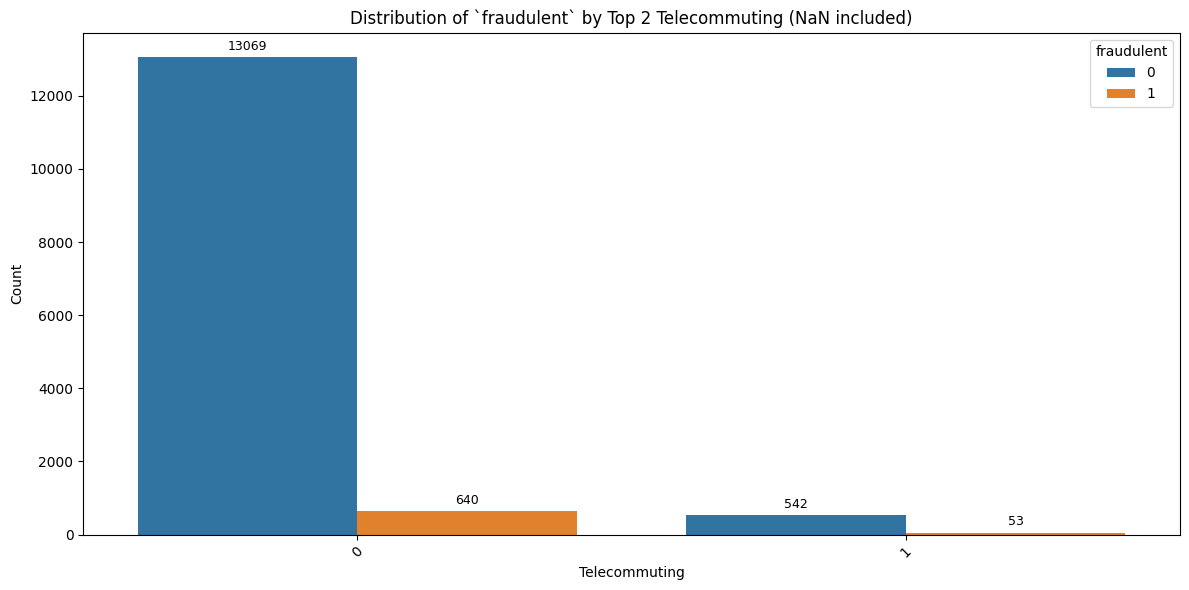

Top 2 'telecommuting' categories cover 100.00% of ALL rows (NaN excluded).
They cover 100.00% of ALL fraudulent postings.
They cover 100.00% of ALL real postings.
Within this subset: 4.84% are fraudulent.
Within this subset: 95.16% are real.


In [ ]:
plot_top_k_distribution(train_df, column='telecommuting')

# `has_company_logo` column

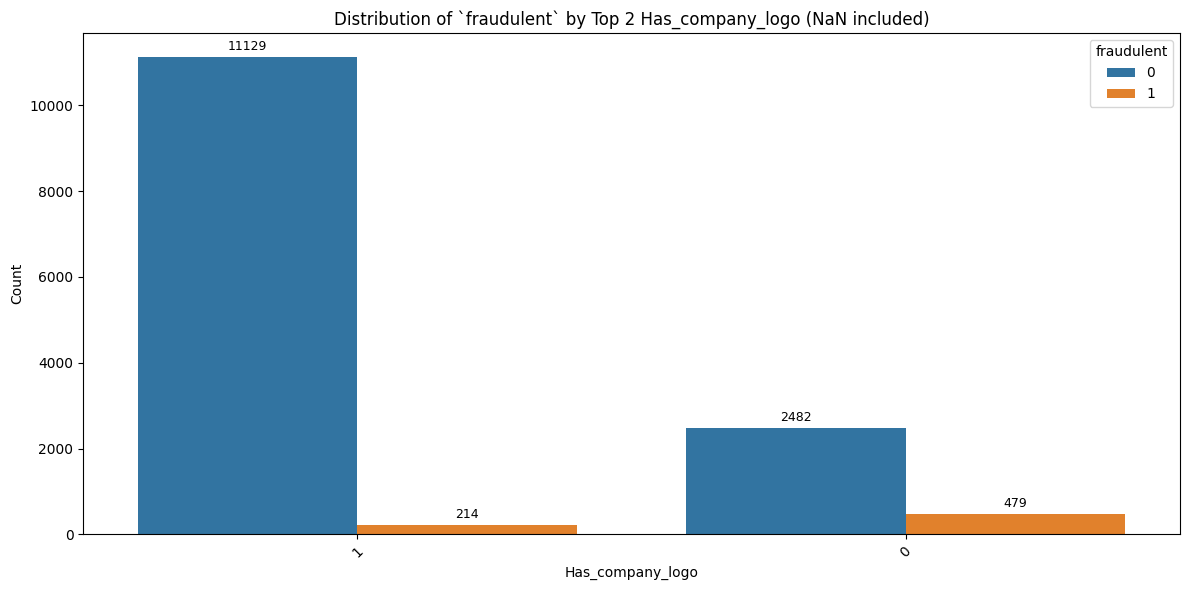

Top 2 'has_company_logo' categories cover 100.00% of ALL rows (NaN excluded).
They cover 100.00% of ALL fraudulent postings.
They cover 100.00% of ALL real postings.
Within this subset: 4.84% are fraudulent.
Within this subset: 95.16% are real.


In [ ]:
plot_top_k_distribution(train_df, column='has_company_logo')

# `has_questions` column

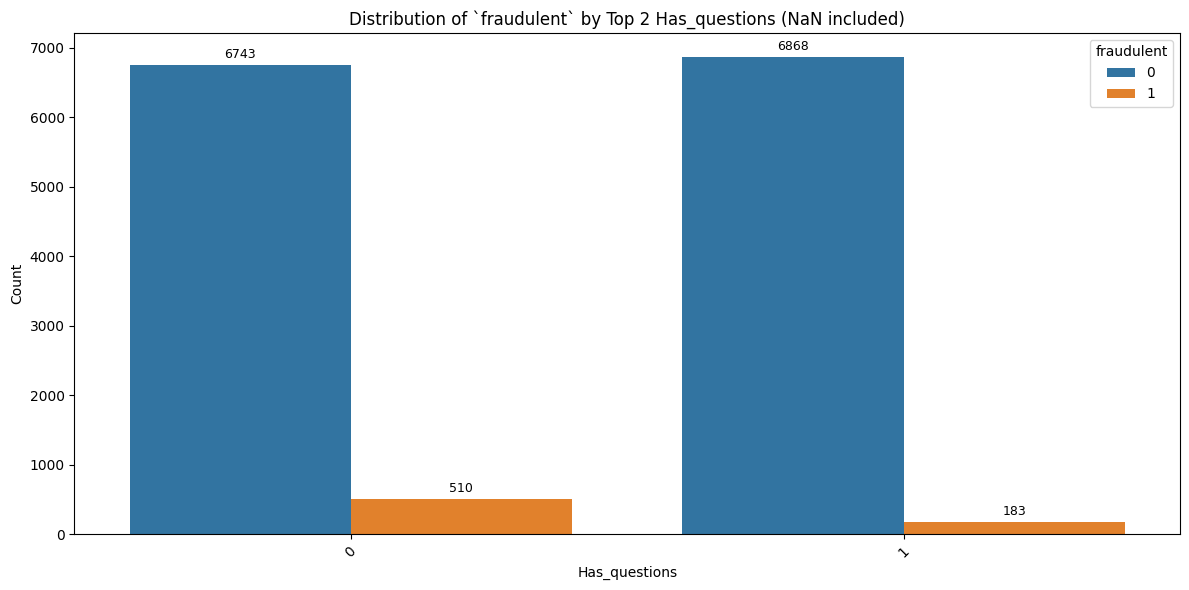

Top 2 'has_questions' categories cover 100.00% of ALL rows (NaN excluded).
They cover 100.00% of ALL fraudulent postings.
They cover 100.00% of ALL real postings.
Within this subset: 4.84% are fraudulent.
Within this subset: 95.16% are real.


In [ ]:
plot_top_k_distribution(train_df, column='has_questions')

# `employment_type` column

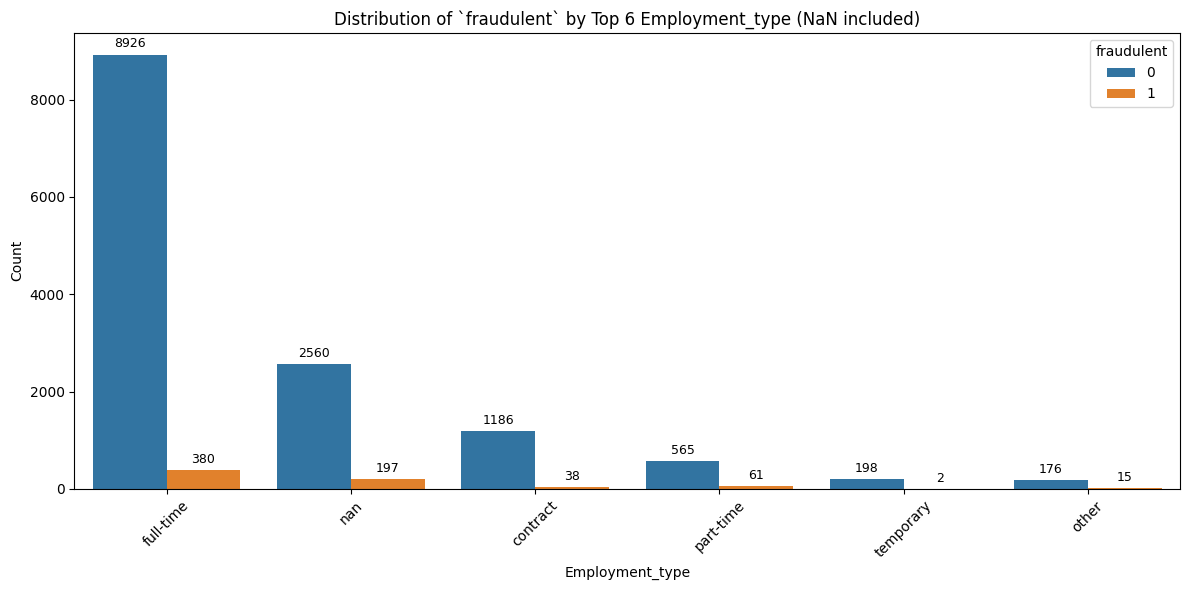

Top 6 'employment_type' categories cover 80.73% of ALL rows (NaN excluded).
They cover 71.57% of ALL fraudulent postings.
They cover 81.19% of ALL real postings.
Within this subset: 4.30% are fraudulent.
Within this subset: 95.70% are real.


In [ ]:
plot_top_k_distribution(train_df, column='employment_type')
# There's a category of "other" observed. We decided to keep it a separate value from null value since this is an indication of other employment type values (e.g. free-lance).

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'employment_type')


--- FULL Missingness Associations for `employment_type` ---

>>> Column: `country`
    • Category `BH` → ONLY appears when `employment_type` is missing (rows: 8)
    • Category `VI` → ONLY appears when `employment_type` is missing (rows: 2)
    >> Total rows for categories with count > 1: 10

>>> Column: `has_employment_type`
    • Category `0` → ONLY appears when `employment_type` is missing (rows: 2757)
    >> Total rows for categories with count > 1: 2757


In [ ]:
print_missing_summary(train_df, ['employment_type'])

# Fradulent postings are more likely to omit the employment type commpared to legitimate postings.

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
employment_type,2757.0,19.2743,197.0,28.4271


# `required_experience` Column

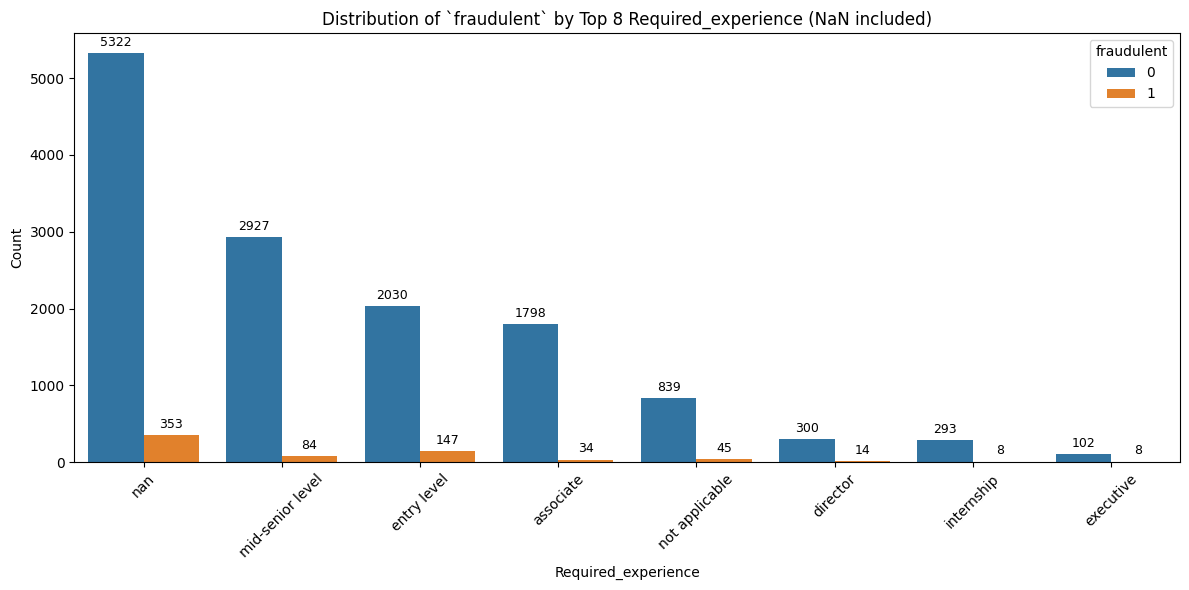

Top 8 'required_experience' categories cover 60.33% of ALL rows (NaN excluded).
They cover 49.06% of ALL fraudulent postings.
They cover 60.90% of ALL real postings.
Within this subset: 3.94% are fraudulent.
Within this subset: 96.06% are real.


In [ ]:
plot_top_k_distribution(train_df, column='required_experience')
# There's a category of "not applicable" observed. We decided to keep it a separate value from null value since this is an indication that there is no required experience for the job.

In [ ]:
train_df_not_applic_exp = train_df[train_df['required_experience'] == "Not Applicable"]
train_df_not_applic_exp.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,title_noencoded,title_clean_has_punctuation,title_clean_no_punctuation,department_noencoded,department_clean_has_punctuation,department_clean_no_punctuation,company_profile_noencoded,company_profile_clean_has_punctuation,company_profile_clean_no_punctuation,description_noencoded,description_clean_has_punctuation,description_clean_no_punctuation,requirements_noencoded,requirements_clean_has_punctuation,requirements_clean_no_punctuation,benefits_noencoded,benefits_clean_has_punctuation,benefits_clean_no_punctuation,title_char_count,title_word_count,title_sentence_count,title_avg_word_length,title_avg_sentence_length,title_unique_word_normalised,title_unique_char_normalised,title_digit_ratio,title_special_char_ratio,title_longest_repeated_chars_length,department_char_count,department_word_count,department_sentence_count,department_avg_word_length,department_avg_sentence_length,department_unique_word_normalised,department_unique_char_normalised,department_digit_ratio,department_special_char_ratio,department_longest_repeated_chars_length,company_profile_char_count,company_profile_word_count,company_profile_sentence_count,company_profile_avg_word_length,company_profile_avg_sentence_length,company_profile_unique_word_normalised,company_profile_unique_char_normalised,company_profile_digit_ratio,company_profile_special_char_ratio,company_profile_longest_repeated_chars_length,description_char_count,description_word_count,description_sentence_count,description_avg_word_length,description_avg_sentence_length,description_unique_word_normalised,description_unique_char_normalised,description_digit_ratio,description_special_char_ratio,description_longest_repeated_chars_length,requirements_char_count,requirements_word_count,requirements_sentence_count,requirements_avg_word_length,requirements_avg_sentence_length,requirements_unique_word_normalised,requirements_unique_char_normalised,requirements_digit_ratio,requirements_special_char_ratio,requirements_longest_repeated_chars_length,benefits_char_count,benefits_word_count,benefits_sentence_count,benefits_avg_word_length,benefits_avg_sentence_length,benefits_unique_word_normalised,benefits_unique_char_normalised,benefits_digit_ratio,benefits_special_char_ratio,benefits_longest_repeated_chars_length,title_contains_remote_keywords,department_contains_remote_keywords,company_profile_contains_remote_keywords,description_contains_remote_keywords,requirements_contains_remote_keywords,benefits_contains_remote_keywords,company_profile_has_url,company_profile_has_email,company_profile_has_phone,company_profile_duplicated,description_has_url,description_has_email,description_has_phone,description_duplicated,requirements_has_url,requirements_has_email,requirements_has_phone,requirements_duplicated,benefits_has_url,benefits_has_email,benefits_has_phone,benefits_duplicated,company_profile_sentiment_pos,company_profile_sentiment_neg,company_profile_sentiment_compound,company_profile_uppercase_ratio,company_profile_exclamation_count,company_profile_exclamation_normalised,company_profile_question_count,company_profile_question_normalised,company_profile_all_caps_words,company_profile_all_caps_words_normalised,description_sentiment_pos,description_sentiment_neg,description_sentiment_compound,description_uppercase_ratio,description_exclamation_count,description_exclamation_normalised,description_question_count,description_question_normalised,description_all_caps_words,description_all_caps_words_normalised,requirements_sentiment_pos,requirements_sentiment_neg,requirements_sentiment_compound,requirements_uppercase_ratio,requirements_exclamation_count,requirements_exclamation_normalised,requirements_question_count,requirements_question_normalised,requirements_all_caps_words,requirements_all_caps

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'required_experience')


--- FULL Missingness Associations for `required_experience` ---

>>> Column: `industry`
    • Category `Furniture` → ONLY appears when `required_experience` is missing (rows: 2)
    >> Total rows for categories with count > 1: 2

>>> Column: `country`
    • Category `BH` → ONLY appears when `required_experience` is missing (rows: 8)
    • Category `BD` → ONLY appears when `required_experience` is missing (rows: 2)
    • Category `VI` → ONLY appears when `required_experience` is missing (rows: 2)
    >> Total rows for categories with count > 1: 12

>>> Column: `has_required_experience`
    • Category `0` → ONLY appears when `required_experience` is missing (rows: 5675)
    >> Total rows for categories with count > 1: 5675


In [ ]:
print_missing_summary(train_df, ['required_experience'])
# Fradulent postings are more likely to omit the required_experience commpared to legitimate postings.

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
required_experience,5675.0,39.6742,353.0,50.938


# `required_education` Column

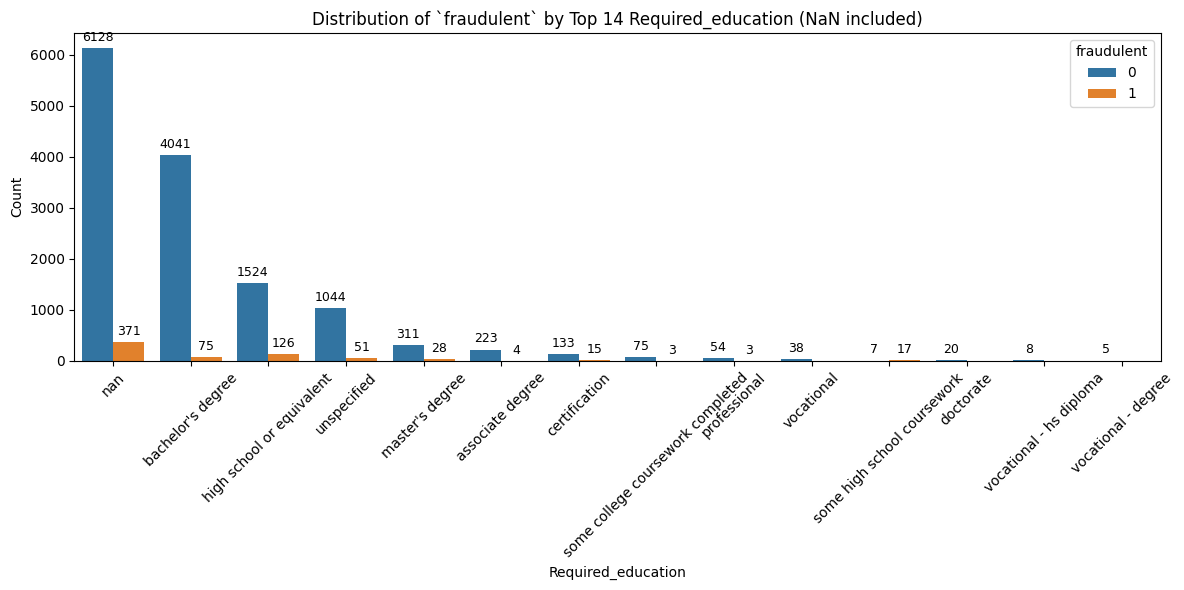

Top 14 'required_education' categories cover 54.57% of ALL rows (NaN excluded).
They cover 46.46% of ALL fraudulent postings.
They cover 54.98% of ALL real postings.
Within this subset: 4.13% are fraudulent.
Within this subset: 95.87% are real.


In [ ]:
plot_top_k_distribution(train_df, column='required_education')
# There's a category of "unspecified" observed. We decided to combine it with null values since they both mean that there are no `required_education` information available.

In [ ]:
def merge_unspecified_education(df, col="required_education"):
    # Combines 'unspecified' with missing values in required_education.
    df = df.copy()

    # Convert values like: 'Unspecified', 'unspecified ', 'UNSPECIFIED'
    df[col] = df[col].replace(
        to_replace=r'^\s*unspecified\s*$',
        value=np.nan,
        regex=True
    )

    return df

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'required_education')


--- FULL Missingness Associations for `required_education` ---

>>> Column: `industry`
    • Category `Fishery` → ONLY appears when `required_education` is missing (rows: 4)
    • Category `Furniture` → ONLY appears when `required_education` is missing (rows: 2)
    >> Total rows for categories with count > 1: 6

>>> Column: `country`
    • Category `LT` → ONLY appears when `required_education` is missing (rows: 20)
    • Category `BY` → ONLY appears when `required_education` is missing (rows: 8)
    • Category `BH` → ONLY appears when `required_education` is missing (rows: 8)
    • Category `BD` → ONLY appears when `required_education` is missing (rows: 2)
    • Category `VI` → ONLY appears when `required_education` is missing (rows: 2)
    • Category `KW` → ONLY appears when `required_education` is missing (rows: 2)
    >> Total rows for categories with count > 1: 42

>>> Column: `has_required_education`
    • Category `0` → ONLY appears when `required_education` is missing (rows: 6

In [ ]:
print_missing_summary(train_df, ['required_education'])
# Fradulent postings are more likely to omit the required_education commpared to legitimate postings.

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
required_education,6499.0,45.4348,371.0,53.5354


# `industry` Column

In [ ]:
train_df['industry'].unique()

array(['Financial Services', 'Telecommunications',
       'Information Technology and Services', 'Building Materials',
       'Internet', nan, 'Computer Games', 'Consumer Services',
       'Marketing and Advertising', 'Environmental Services',
       'Medical Practice', 'Education Management',
       'Hospital & Health Care', 'Computer Software', 'Executive Office',
       'Events Services', 'Mechanical or Industrial Engineering',
       'Retail', 'Apparel & Fashion', 'Health, Wellness and Fitness',
       'Cosmetics', 'E-Learning', 'Food & Beverages',
       'Electrical/Electronic Manufacturing', 'Real Estate', 'Design',
       'Online Media', 'Facilities Services', 'Aviation & Aerospace',
       'Legal Services', 'Hospitality', 'Banking', 'Automotive',
       'Chemicals', 'Broadcast Media', 'Oil & Energy',
       'Computer Hardware', 'Computer Networking',
       'Nonprofit Organization Management', 'Entertainment',
       'Human Resources', 'Venture Capital & Private Equity',
      

## a. Analysis of Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'industry')


--- FULL Missingness Associations for `industry` ---

>>> Column: `country`
    • Category `BH` → ONLY appears when `industry` is missing (rows: 8)
    • Category `VI` → ONLY appears when `industry` is missing (rows: 2)
    >> Total rows for categories with count > 1: 10

>>> Column: `has_industry`
    • Category `0` → ONLY appears when `industry` is missing (rows: 3926)
    >> Total rows for categories with count > 1: 3926


In [ ]:
print_missing_summary(train_df, ['industry'])

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
industry,3926.0,27.4469,226.0,32.6118


# `function` Column

In [ ]:
train_df['function'].unique()
# There's a category "other", but decided to keep it separate from null values since this is an indication of alternative job functions rather than missingness.

array(['Customer Service', nan, 'Sales', 'Marketing', 'Management',
       'Information Technology', 'Administrative', 'Consulting',
       'Education', 'Health Care Provider', 'Accounting/Auditing',
       'Legal', 'Engineering', 'Design', 'Business Development',
       'Project Management', 'Business Analyst', 'Other',
       'Human Resources', 'Writing/Editing', 'Data Analyst', 'Finance',
       'Product Management', 'Research', 'Manufacturing',
       'Public Relations', 'Training', 'Art/Creative',
       'Quality Assurance', 'Advertising', 'Distribution',
       'Strategy/Planning', 'General Business', 'Production',
       'Financial Analyst', 'Supply Chain', 'Science', 'Purchasing'],
      dtype=object)

## a. Analyse Missing Values

In [ ]:
analyse_fully_missing_categories(train_df_compare, 'function')


--- FULL Missingness Associations for `function` ---

>>> Column: `country`
    • Category `BY` → ONLY appears when `function` is missing (rows: 8)
    • Category `BH` → ONLY appears when `function` is missing (rows: 8)
    • Category `VI` → ONLY appears when `function` is missing (rows: 2)
    >> Total rows for categories with count > 1: 18

>>> Column: `has_function`
    • Category `0` → ONLY appears when `function` is missing (rows: 5169)
    >> Total rows for categories with count > 1: 5169


In [ ]:
print_missing_summary(train_df, ['function'])

,missing_count,missing_pct,missing_and_fraud_count,missing_and_fraud_pct_of_fraud
function,5169.0,36.1367,273.0,39.3939


# Interaction Features

In [ ]:
# Creates:
#       - remote_text_flag: 1 if ANY text_col contains remote keywords
#       - mismatch_remote: 1 ONLY IF remote text appears but telecommuting == 0

def add_mismatch_remote_indication(df, text_cols, tele_col="telecommuting"):

    df = df.copy()

    # 1) Combine text remote flags
    df["remote_text_flag"] = df.apply(
        lambda row: int(any(row.get(f"{col}_contains_remote_keywords", False)
                            for col in text_cols)),
        axis=1
    )

    # 2) mismatch = remote_text_flag == 1 AND telecommuting == 0
    df["mismatch_remote"] = (
        (df["remote_text_flag"] == 1) &
        (df[tele_col] == 0)
    ).astype(int)

    return df

In [ ]:
train_df = add_mismatch_remote_indication(train_df, TEXT_COLS)

# Handling high-cardinality columns

In [ ]:
# top_k (list): categories covering at least `coverage` fraction of the data

def get_top_k_strict(series, coverage=0.90):
    vc = series.value_counts(normalize=True)
    cum = vc.cumsum()

    # Find the minimum index where cumulative ≥ coverage
    idx = cum.searchsorted(coverage, side="left")  # ensures ≥ coverage, not close to

    # Top-K categories
    top_k = list(vc.index[:idx+1])

    summary = {
        "top_k_count": len(top_k),
        "total_unique": series.nunique(),
        "achieved_coverage": cum.iloc[idx]
    }

    return top_k, summary


COLUMNS_TO_CHECK = ["country", "industry", "function"]

topk_results = {}

for col in COLUMNS_TO_CHECK:
    print(f"Top-K Strict 90% Coverage for: {col}")

    top_k, summary = get_top_k_strict(train_df[col], coverage=0.90)
    topk_results[col] = top_k

    print(f"Total unique categories in `{col}`            : {summary['total_unique']}")
    print(f"Number of Top-K categories (>= 90% coverage): {summary['top_k_count']}")
    print(f"Achieved coverage                           : {summary['achieved_coverage']*100:.4f}%")

Top-K Strict 90% Coverage for: country
Total unique categories in `country`            : 88
Number of Top-K categories (>= 90% coverage): 10
Achieved coverage                           : 90.7230%
Top-K Strict 90% Coverage for: industry
Total unique categories in `industry`            : 129
Number of Top-K categories (>= 90% coverage): 48
Achieved coverage                           : 90.1330%
Top-K Strict 90% Coverage for: function
Total unique categories in `function`            : 37
Number of Top-K categories (>= 90% coverage): 19
Achieved coverage                           : 90.3667%


In [ ]:
# Plots the cumulative coverage of categories sorted by frequency.
# Shows:
#     - Cumulative coverage line
#     - 90% threshold
#     - Top-K cutoff point
def plot_top_k_coverage(series, col_name, coverage=0.90):
    vc = series.value_counts(normalize=True)
    cum = vc.cumsum()

    # Find index where cumulative >= coverage
    idx = cum.searchsorted(coverage, side="left")
    cutoff_coverage = cum.iloc[idx]

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cum)+1), cum.values, marker='o', markersize=3)
    plt.axhline(coverage, color='red', linestyle='--', label=f"{coverage*100:.0f}% threshold")
    plt.axvline(idx+1, color='green', linestyle='--',
                label=f"Top-K = {idx+1} (Coverage = {cutoff_coverage*100:.2f}%)")

    plt.title(f"Cumulative Coverage Curve for '{col_name}'")
    plt.xlabel("Number of Top Categories Included")
    plt.ylabel("Cumulative Coverage")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting cumulative coverage for: country


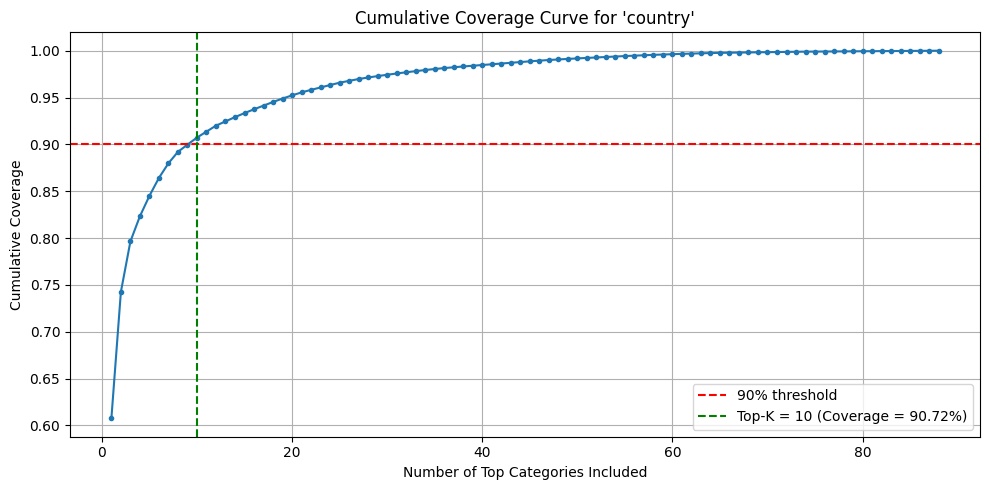


Plotting cumulative coverage for: industry


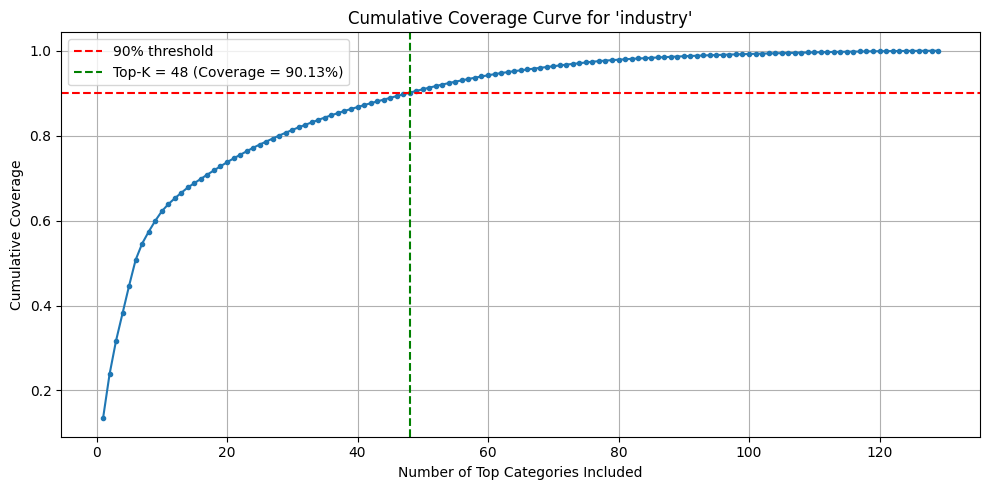


Plotting cumulative coverage for: function


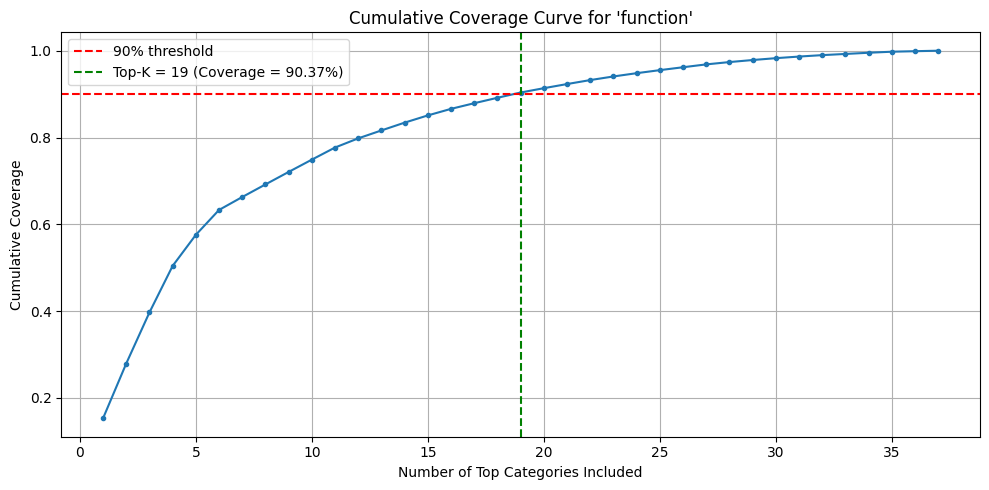

In [ ]:
for col in COLUMNS_TO_CHECK:
    print(f"\nPlotting cumulative coverage for: {col}")
    plot_top_k_coverage(train_df[col], col_name=col, coverage=0.90)

In [ ]:
# To group small categories into the big category of "rare"
# TRAIN MODE (is_train=True):
#     - Computes Top-K categories for each column (strict >= coverage)
#     - Collapses rare categories into placeholder
#     - Returns df, state_with_topk, summary

# TEST MODE (is_train=False):
#     - Uses stored Top-K categories in `state`
#     - Collapses rare categories accordingly
#     - Returns df only

# Returns:
#     df_modified
#     state (only in train)
#     summary_dict (only in train)

def collapse_rare_categories_df(df, columns, coverage=0.90, placeholder="RARE CATEGORY",
                                is_train=True, state=None):

    df = df.copy()

    # Inner helper functions
    def get_top_k_strict(series, coverage):
        vc = series.dropna().value_counts(normalize=True)
        cum = vc.cumsum()
        idx = cum.searchsorted(coverage, side="left")   # strict ≥ 90%
        top_k = list(vc.index[:idx + 1])
        summary = {
            "top_k_count": len(top_k),
            "total_unique_non_null": series.dropna().nunique(),
            "achieved_coverage": float(cum.iloc[idx])
        }
        return top_k, summary

    def collapse(series, top_k, placeholder):
        return series.apply(
            lambda x: x if (pd.isna(x) or x in top_k) else placeholder
        )

    # TRAIN MODE
    if is_train:

        topk_dict = {}
        summary_dict = {}

        print("\n=== TRAIN MODE: Computing Top-K categories ===")

        for col in columns:
            print(f"\n--- Processing column: {col} ---")

            top_k, summary = get_top_k_strict(df[col], coverage)
            df[col] = collapse(df[col], top_k, placeholder)

            topk_dict[col] = top_k
            summary_dict[col] = summary

            print(f"Total unique non-null categories      : {summary['total_unique_non_null']}")
            print(f"Top-K categories retained             : {summary['top_k_count']}")
            print(f"Achieved coverage                     : {summary['achieved_coverage']*100:.2f}%")
            print(f"Top-K categories (first 20 shown)     : {top_k[:20]}")

        # store Top-K list in state
        state_out = {"topk_categories": topk_dict}

        return df, state_out, summary_dict

    # TEST MODE
    else:
        if state is None or "topk_categories" not in state:
            raise ValueError("ERROR: topk_categories missing — you must pass state from TRAIN MODE.")

        topk_dict = state["topk_categories"]

        print("\n=== TEST MODE: Applying stored Top-K categories ===")

        for col in columns:
            print(f"\n--- Processing column (TEST): {col} ---")

            top_k = topk_dict[col]
            df[col] = collapse(df[col], top_k, placeholder)

            print(f"Applied Top-K categories from train (kept {len(top_k)} categories).")

        return df

In [ ]:
HIGH_CARD_COLS = ["country", "industry", "function"]

train_df, rare_state, rare_summary = collapse_rare_categories_df(
    train_df,
    columns=HIGH_CARD_COLS,
    is_train=True
)


=== TRAIN MODE: Computing Top-K categories ===

--- Processing column: country ---
Total unique non-null categories      : 88
Top-K categories retained             : 10
Achieved coverage                     : 90.72%
Top-K categories (first 20 shown)     : ['US', 'GB', 'GR', 'CA', 'DE', 'NZ', 'IN', 'AU', 'NL', 'PH']

--- Processing column: industry ---
Total unique non-null categories      : 129
Top-K categories retained             : 48
Achieved coverage                     : 90.13%
Top-K categories (first 20 shown)     : ['Information Technology and Services', 'Computer Software', 'Internet', 'Education Management', 'Marketing and Advertising', 'Financial Services', 'Hospital & Health Care', 'Consumer Services', 'Telecommunications', 'Oil & Energy', 'Retail', 'Real Estate', 'Accounting', 'Construction', 'Design', 'Management Consulting', 'E-Learning', 'Staffing and Recruiting', 'Health, Wellness and Fitness', 'Automotive']

--- Processing column: function ---
Total unique non-null ca

# Handling of missing values

In [ ]:
def handle_missing_values(df, state=None, return_state=False):
    df = df.copy()

    # 1. Missing indicator columns
    df["company_profile_missing"] = df["company_profile"].isna().astype(int)
    df["requirements_missing"] = df["requirements"].isna().astype(int)
    df["benefits_missing"] = df["benefits"].isna().astype(int)
    df["salary_range_missing"] = df["salary_range"].isna().astype(int)
    df["department_missing"] = df["department"].isna().astype(int)

    # 2. Fill missing TEXT columns
    text_cols = ["title", "country", "company_profile", "description", "requirements", "benefits", "employment_type", "required_experience", "required_education", "industry", "function"]
    for col in text_cols:
        df[col] = df[col].fillna("")


    # 3. Fill missing binary/categorical cols using TRAINING mode or fe_state
    mode_cols = ["telecommuting", "has_company_logo", "has_questions"]

    # TRAINING mode: compute and store mode values
    if state is None:
        state = {"missing_value_modes": {}}
        for col in mode_cols:
            mode_value = df[col].mode(dropna=True)[0]
            df[col] = df[col].fillna(mode_value)
            state["missing_value_modes"][col] = mode_value

    # TEST mode: reuse stored values
    else:
        for col in mode_cols:
            mode_value = state["missing_value_modes"][col]
            df[col] = df[col].fillna(mode_value)

    # return results
    if return_state:
        return df, state
    else:
        return df


In [ ]:
train_df = handle_missing_values(train_df)

# Full feature engineering function to apply on test data

In [ ]:
# Main function to execute feature engineering steps
def apply_feature_engineering(df, is_train=True, fe_state=None):
    df = df.copy()

    # If training, create empty fe_state container
    if is_train:
        fe_state = {}

    # 1. Text preprocessing
    df = preprocess_text_columns(df, TEXT_COLS)
    df = add_text_statistics(df, TEXT_COLS)
    df = add_contact_info_and_dup_indicator_to_text_cols(df, LONG_TEXT_COLS)
    df = add_sentiment_features(df, LONG_TEXT_COLS)
    df = add_readability_and_quality_features(df, LONG_TEXT_COLS)
    df = add_pos_tagging(df, LONG_TEXT_COLS)

    # 2. Location processing
    df = split_location_columns(df)
    df = add_location_features(df)

    # 3. Title, salary, etc.
    df = add_is_date_like_salary(df, "salary_range")
    df = add_title_features(df, "title")
    df = add_invalid_department_flag(df, "department")
    df = preprocess_and_add_domain_features(df, TEXT_COLS)
    df = add_mismatch_remote_indication(df, TEXT_COLS)

    # 4. HIGH-CARDINALITY COLLAPSE-
    HIGH_CARD_COLS = ["country", "industry", "function"]

    if is_train:
        df, hc_state, hc_summary = collapse_rare_categories_df(
            df,
            columns=HIGH_CARD_COLS,
            coverage=0.90,
            placeholder="RARE CATEGORY",
            is_train=True
        )
        fe_state["high_cardinality"] = hc_state
        fe_state["high_cardinality_summary"] = hc_summary

    else:
        df = collapse_rare_categories_df(
            df,
            columns=HIGH_CARD_COLS,
            coverage=0.90,
            placeholder="RARE CATEGORY",
            is_train=False,
            state=fe_state["high_cardinality"]
        )

    # 5. Missing value handling (train-safe)
    if is_train:
        df, missing_state = handle_missing_values(df, return_state=True)
        fe_state["missing_values"] = missing_state
    else:
        df = handle_missing_values(df, state=fe_state["missing_values"], return_state=False)

    # RETURN
    if is_train:
        return df, fe_state
    else:
        return df


In [ ]:
train_df_fe, fe_state = apply_feature_engineering(train_df_copy, is_train=True)
train_df_fe.to_csv(f"{FILE_PATH}full_engineered_train_df.csv", index=False)


=== TRAIN MODE: Computing Top-K categories ===

--- Processing column: country ---
Total unique non-null categories      : 88
Top-K categories retained             : 10
Achieved coverage                     : 90.72%
Top-K categories (first 20 shown)     : ['US', 'GB', 'GR', 'CA', 'DE', 'NZ', 'IN', 'AU', 'NL', 'PH']

--- Processing column: industry ---
Total unique non-null categories      : 129
Top-K categories retained             : 48
Achieved coverage                     : 90.13%
Top-K categories (first 20 shown)     : ['Information Technology and Services', 'Computer Software', 'Internet', 'Education Management', 'Marketing and Advertising', 'Financial Services', 'Hospital & Health Care', 'Consumer Services', 'Telecommunications', 'Oil & Energy', 'Retail', 'Real Estate', 'Accounting', 'Construction', 'Design', 'Management Consulting', 'E-Learning', 'Staffing and Recruiting', 'Health, Wellness and Fitness', 'Automotive']

--- Processing column: function ---
Total unique non-null ca

In [ ]:
test_df_fe = apply_feature_engineering(test_df, is_train=False, fe_state=fe_state)
test_df_fe.to_csv(f"{FILE_PATH}full_engineered_test_df.csv", index=False)


=== TEST MODE: Applying stored Top-K categories ===

--- Processing column (TEST): country ---
Applied Top-K categories from train (kept 10 categories).

--- Processing column (TEST): industry ---
Applied Top-K categories from train (kept 48 categories).

--- Processing column (TEST): function ---
Applied Top-K categories from train (kept 19 categories).


# Analyse engineered features for downstream classical ML models

## a. Generic Checks

In [ ]:
train_df = pd.read_csv(f"{FILE_PATH}full_engineered_train_df.csv", keep_default_na=True) # automatically treat certain null values as "NaN"
test_df = pd.read_csv(f"{FILE_PATH}full_engineered_test_df.csv", keep_default_na=True)

In [ ]:
# Checking null values in each col
train_df.isna().sum()

In [ ]:
for col in train_df.columns:
  print(col)

## b. Defining categorical & numerical features

In [ ]:
TEXT_COLS = ["title", "department", "company_profile", "description", "requirements", "benefits"]
LONG_TEXT_COLS = ["company_profile", "description", "requirements", "benefits"]

#-- Categorical features
categorical_features = [
    "telecommuting", "has_company_logo", "has_questions",
    "employment_type", "required_experience", "required_education",
    "industry", "function",
    "country", "invalid_state", "US_listing_without_state_info",
    "is_multi_location_in_city",
    "salary_range_is_date_like",
    "title_contains_action_word", "title_seniority_level",
    "department_invalid_dept",
    "mismatch_remote",
] + \
[
    f"{field}_contains_remote_keywords" for field in TEXT_COLS
] + \
[
    f"{field}_missing" for field in ["department", "company_profile", "requirements", "benefits"]
]


#-- Numerical features
text_stats_suffixes = [
    "char_count", "word_count",
    "avg_word_length", "avg_sentence_length",
    "unique_word_normalised", "unique_char_normalised",
    "digit_ratio", "special_char_ratio",
    "longest_repeated_chars_length"
]

extra_suffixes = [
    "sentence_count", "has_url", "has_email", "has_phone", "duplicated",
    "sentiment_pos", "sentiment_neg", "sentiment_compound",
    "uppercase_ratio", "exclamation_count", "exclamation_normalised",
    "question_count", "question_normalised",
    "all_caps_words", "all_caps_words_normalised",
    "flesch_score", "gunning_fog", "spelling_error_rate", "objective_score",
    "POS_NOUN_normalised", "POS_VERB_normalised", "POS_ADJ_normalised",
    "POS_NUM_normalised", "POS_DET_normalised", "POS_ADP_normalised",
    "POS_CONJ_normalised", "POS_PRON_normalised", "POS_PRT_normalised",
    "POS_ADV_normalised", "POS_X_normalised",
    "POS_TOTAL_TOKENS"
]

numerical_features = [
    f"{field}_{suffix}"
    for field in TEXT_COLS
    for suffix in text_stats_suffixes
] + [
    f"{field}_{suffix}"
    for field in LONG_TEXT_COLS
    for suffix in extra_suffixes
] + [
    "location_segment_count"
]

## c. Checking for transformation required

In [ ]:
# Plot bar plots for categorical columns and histograms for numerical columns.
def plot_features(df, cat_cols=None, num_cols=None, bins=20):

    # List of categorical feature names
    if cat_cols is None:
        cat_cols = []
    # List of numerical feature names
    if num_cols is None:
        num_cols = []

    total_plots = len(cat_cols) + len(num_cols)
    if total_plots == 0:
        print("No features provided.")
        return

    # Layout: automatically determine rows/cols
    cols = 3
    rows = (total_plots + cols - 1) // cols

    plt.figure(figsize=(6 * cols, 5 * rows))

    plot_index = 1

    # Plot categorical bar plots
    for col in cat_cols:
        plt.subplot(rows, cols, plot_index)
        value_counts = df[col].fillna("Missing").value_counts()

        sns.barplot(x=value_counts.index, y=value_counts.values)
        plt.title(f"Categorical: {col}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Count")
        plt.tight_layout()
        plot_index += 1

    # Plot numerical histograms
    for col in num_cols:
        plt.subplot(rows, cols, plot_index)
        sns.histplot(df[col].dropna(), bins=bins, kde=False)
        plt.title(f"Numerical: {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plot_index += 1

    plt.show()

In [ ]:
plot_features(train_df, cat_cols=categorical_features, num_cols=numerical_features)

In [ ]:
# Detect which features need log-transform
def automatic_log_transform_candidates(df, numerical_features,
                                       skew_threshold=1.0,
                                       kurt_threshold=3.0):

    results = []

    for col in numerical_features:

        if col not in df.columns:
            continue  # skip missing columns

        series = df[col].dropna()

        # Skip if constant or empty
        if series.nunique() <= 1:
            results.append([col, np.nan, np.nan, None, "SKIP (constant)"])
            continue

        # Calculate stats
        col_skew = skew(series)
        col_kurt = kurtosis(series)
        pct_zero = (series == 0).mean()

        # Decision rules
        if series.min() < 0:
            decision = "NO (negative values)"
        elif series.max() <= 1:
            decision = "NO (ratio or proportion <= 1)"
          # right-skewed columns
        elif abs(col_skew) > skew_threshold:
            decision = "YES"
        else:
            decision = "NO"

        results.append([col, col_skew, col_kurt, pct_zero, decision])

    summary_df = pd.DataFrame(
        results,
        columns=["feature", "skew", "kurtosis", "% zeros", "log_transform?"]
    )

    features_to_log = summary_df[summary_df["log_transform?"] == "YES"]["feature"].tolist()
    return features_to_log, summary_df


# Apply log1p transform to selected features.
# Produces new columns <col>_log.
def apply_log_transforms(df, features_to_log):
    df = df.copy()

    for col in features_to_log:
        # clip negatives to zero and apply log1p
        df[f"{col}_log"] = np.log1p(df[col].clip(lower=0))

    return df


# TRAIN-TIME: detect + apply + return state
def fit_log_transformer(df_train, numerical_features,
                        skew_threshold=1.0, kurt_threshold=3.0):
    # TRAIN PHASE:
    #   - Detects log-transform features
    #   - Applies log-transforms to train data
    #   - Returns:
    #         df_train_logged
    #         log_state (features_to_log)
    #         summary_df

    # Step 1 — detect
    features_to_log, summary_df = automatic_log_transform_candidates(
        df_train, numerical_features,
        skew_threshold=skew_threshold,
        kurt_threshold=kurt_threshold
    )

    print("\n=== FEATURES SELECTED FOR LOG TRANSFORM (TRAIN) ===")
    for feat in features_to_log:
        print(f"  - {feat}")

    # Step 2 — apply transform to training data
    df_train_logged = apply_log_transforms(df_train, features_to_log)

    # Step 3 — store the state
    log_state = {"features_to_log": features_to_log}

    return df_train_logged, log_state, summary_df



#  TEST-TIME: apply ONLY train-selected logs
# Applies log1p to the same features selected during training only.
# Prevents data leakage.

def transform_log_test(df_test, log_state):
    features_to_log = log_state["features_to_log"]

    print("\n=== Applying LOG TRANSFORM to TEST data for these columns ===")
    for feat in features_to_log:
        print(f"  - {feat}")

    df_test_logged = apply_log_transforms(df_test, features_to_log)
    return df_test_logged


# Replace raw features with *_log in final list
# If a feature was log-transformed, replace it with <feature>_log.
# Otherwise keep it unchanged.

def build_final_numerical_features(numerical_features, features_to_log):
    final_list = []
    for col in numerical_features:
        if col in features_to_log:
            final_list.append(f"{col}_log")
        else:
            final_list.append(col)

    return final_list

In [ ]:
# Training
train_df_logged, log_state, log_summary = fit_log_transformer(
    train_df, numerical_features
)

In [ ]:
# Final numerical feature list
final_numerical_features = build_final_numerical_features(
    numerical_features,
    log_state["features_to_log"]
)
final_numerical_features

In [ ]:
train_df_logged.to_csv(f"{FILE_PATH}full_engineered_train_df_with_log.csv", index=False)

In [ ]:
test_df_logged = transform_log_test(test_df, log_state)
test_df_logged.to_csv(f"{FILE_PATH}full_engineered_test_df_with_log.csv", index=False)

# Generating Data for Clustering Analysis

This version does not compress high cardinality columns and retain all raw + logged features.

In [ ]:
def apply_feature_engineering_for_clustering(df, is_train=True):
    df = df.copy()

    # If training, create empty fe_state container
    if is_train:
        fe_state = {}

    # 1. Text preprocessing
    df = preprocess_text_columns(df, TEXT_COLS)
    df = add_text_statistics(df, TEXT_COLS)
    df = add_contact_info_and_dup_indicator_to_text_cols(df, LONG_TEXT_COLS)
    df = add_sentiment_features(df, LONG_TEXT_COLS)
    df = add_readability_and_quality_features(df, LONG_TEXT_COLS)
    df = add_pos_tagging(df, LONG_TEXT_COLS)

    # 2. Location processing
    df = split_location_columns(df)
    df = add_location_features(df)

    # 3. Title, salary, etc.
    df = add_is_date_like_salary(df, "salary_range")
    df = add_title_features(df, "title")
    df = add_invalid_department_flag(df, "department")
    df = preprocess_and_add_domain_features(df, TEXT_COLS)
    df = add_mismatch_remote_indication(df, TEXT_COLS)

    return df

In [ ]:
train_df_fe_clustering = apply_feature_engineering_for_clustering(train_df_raw_clustering)
test_df_fe_clustering = apply_feature_engineering_for_clustering(test_df_raw_clustering)

In [ ]:
train_df_logged_clustering, log_clustering_state, log_clustering_summary = fit_log_transformer(
    train_df_fe_clustering, numerical_features
)
test_df_logged_clustering = transform_log_test(test_df_fe_clustering, log_clustering_state)

In [ ]:
log_feature_names = [f + "_log" for f in log_clustering_state["features_to_log"]]
all_numerical_features = numerical_features + log_feature_names
all_categorical_features = categorical_features

In [ ]:
train_df_logged_clustering.to_csv(f"{FILE_PATH}clustering_train_df.csv", index=False)
test_df_logged_clustering.to_csv(f"{FILE_PATH}clustering_test_df.csv", index=False)